In [153]:
from sklearn.metrics import roc_auc_score, roc_curve
from neptune.integrations.lightgbm import NeptuneCallback, create_booster_summary
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from datetime import datetime, date
import seaborn as sns
import lightgbm as lgb
import numpy as np
import pandas as pd
import neptune


# Load Data
* Handle missing values, duplicated values, outlier

In [154]:
total = pd.read_csv("https://raw.githubusercontent.com/lavibula/ML20222.PredictionBitcoin/main/data/saved_data.csv")
total['Date'] = pd.to_datetime(total['Date'])

df = total.set_index('Date')
df.head()

,BTC_close,BTC_open,BTC_high,BTC_low,BTC_volume,Active_Addr_Cnt,Difficulty,Mean_Block_Size(in_bytes),Sum_Block_Weight,Total_Fees(USD),...,ETH,LTC,DOGE,XRP,GOLD,SILVER,COPPER,S&P500,DJI,JP225
Date,,,,,,,,,,,,,,,,,,,,,
2023-04-16,30310.3,30299.2,30545.3,30134.6,34.48,840992.0,4.788780e+13,1866594.290,495223185.0,484205.915377,...,2119.29,100.03,0.090465,0.52089,2015.6,25.438,9023.5,4137.64,33885.31,28493.47
2023-04-15,30299.6,30472.6,30586.5,30208.8,31.71,1045660.0,4.788780e+13,1839875.354,631025193.0,630623.285367,...,2090.59,96.66,0.088890,0.51930,2002.2,25.460,9023.5,4137.64,33885.31,28493.47
2023-04-14,30472.5,30387.4,30964.9,30026.0,98.38,1016042.0,4.788780e+13,1759535.436,559166432.0,858535.297189,...,2099.98,96.34,0.088707,0.52269,2002.2,25.460,9023.5,4137.64,33885.31,28493.47
2023-04-13,30387.4,29892.4,30524.1,29864.5,65.87,1009669.0,4.788780e+13,1812112.549,567094231.0,767012.808110,...,2012.11,94.19,0.087344,0.51244,2041.3,25.925,9058.5,4146.22,34030.34,28156.97
2023-04-12,29886.4,30209.8,30473.0,29679.5,78.69,1056542.0,4.788780e+13,1933495.919,635037442.0,757368.783682,...,1916.58,92.02,0.083398,0.50473,2010.9,25.458,8916.5,4091.95,33647.22,28082.70


In [155]:
df.shape

(4654, 23)

In [156]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4654 entries, 2023-04-16 to 2010-07-20
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   BTC_close                   4654 non-null   float64
 1   BTC_open                    4654 non-null   float64
 2   BTC_high                    4654 non-null   float64
 3   BTC_low                     4654 non-null   float64
 4   BTC_volume                  4654 non-null   float64
 5   Active_Addr_Cnt             4654 non-null   float64
 6   Difficulty                  4654 non-null   float64
 7   Mean_Block_Size(in_bytes)   4654 non-null   float64
 8   Sum_Block_Weight            4654 non-null   float64
 9   Total_Fees(USD)             4654 non-null   float64
 10  Mean_Hashrate               4654 non-null   float64
 11  Xfer_Cnt                    4654 non-null   float64
 12  Mean_Tx_size(native_units)  4654 non-null   float64
 13  ETH            

In [157]:
df.describe()

,BTC_close,BTC_open,BTC_high,BTC_low,BTC_volume,Active_Addr_Cnt,Difficulty,Mean_Block_Size(in_bytes),Sum_Block_Weight,Total_Fees(USD),...,ETH,LTC,DOGE,XRP,GOLD,SILVER,COPPER,S&P500,DJI,JP225
count,4654.000000,4654.000000,4654.000000,4654.000000,4654.000000,4.654000e+03,4.654000e+03,4.654000e+03,4.654000e+03,4.654000e+03,...,4654.000000,4654.000000,4654.000000,4654.000000,4654.000000,4654.000000,4654.000000,4654.000000,4654.000000,4654.000000
mean,8950.828126,8944.396197,9182.648904,8680.543532,144.272183,4.974545e+05,7.399910e+12,6.883463e+05,3.329426e+08,5.498044e+05,...,505.010290,45.052975,0.026408,0.229873,1474.337129,21.657901,7112.199345,2492.349280,21487.496401,18751.425404
std,14517.759120,14515.100053,14900.138248,14078.916437,199.685947,3.731797e+05,1.103629e+13,4.990862e+05,2.151278e+08,1.528054e+06,...,945.449318,63.364718,0.069391,0.334681,253.778406,6.479395,1491.343889,989.044608,7511.506584,6322.971966
min,0.100000,0.100000,0.100000,0.000000,0.170000,4.080000e+02,1.820000e+02,4.164167e+02,2.841400e+05,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,1049.600000,11.772000,0.000000,1047.220000,9985.810000,8160.010000
25%,140.475000,140.400000,145.800000,135.825000,25.407500,8.702175e+04,1.322172e+08,1.656955e+05,1.124594e+08,3.741492e+03,...,0.000000,0.000000,0.000000,0.000000,1260.025000,16.624500,5947.125000,1697.435000,15464.300000,14313.030000
50%,916.050000,915.050000,934.150000,877.350000,63.605000,5.389900e+05,2.840750e+11,7.887917e+05,4.066180e+08,6.090908e+04,...,12.430000,3.870000,0.000000,0.008870,1371.850000,19.570000,6962.000000,2204.720000,19161.280000,19435.830000
75%,9932.450000,9926.450000,10231.950000,9636.050000,158.375000,8.174050e+05,1.389755e+13,1.087807e+06,5.072356e+08,4.321621e+05,...,396.107500,67.199500,0.003335,0.350712,1721.025000,25.340750,8151.437500,3046.155000,26828.202500,22902.512500
max,67527.900000,67528.700000,68990.600000,66334.900000,999.530000,1.366494e+06,4.788780e+13,2.535436e+06,7.584308e+08,2.139776e+07,...,4808.380000,386.820000,0.686880,2.780000,2069.400000,48.599000,10674.000000,4796.560000,36799.650000,30670.100000


<Axes: >

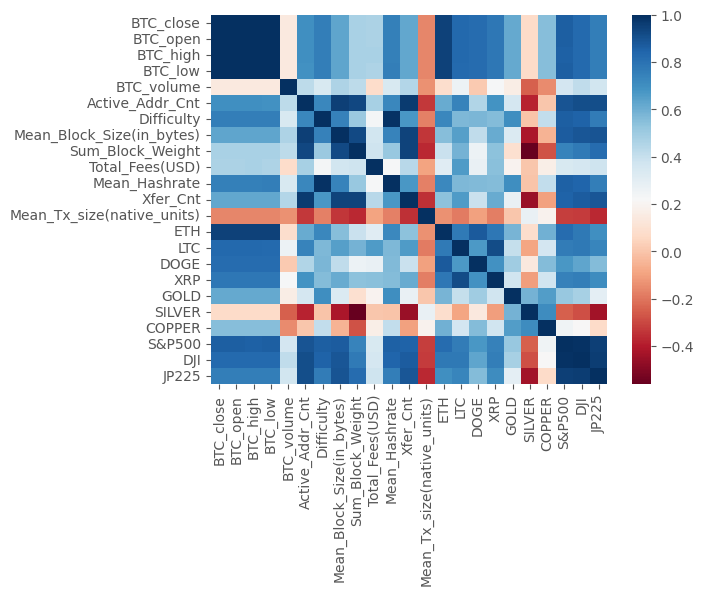

In [158]:
sns.heatmap(df.corr(), cmap="RdBu")

# Slpit Data (Testing, Training Data Sets)

In [159]:
from datetime import datetime

for index in total.index:
    total.loc[index, "Date"] = datetime.strptime(str(total.loc[index, "Date"])[:10], '%Y-%m-%d').date()

Start_day = date(2016, 3, 10)
Test_day = date(2021,6,16)
End_day = date(2023,4,16)


# train, test
total = total[(total["Date"] >= Start_day) & (total["Date"] <= End_day)].reset_index(drop = True)
train_dataset = total[total["Date"] < Test_day].reset_index(drop = True)
test_dataset = total[total["Date"] >= Test_day].reset_index(drop = True)


In [160]:
X_train = train_dataset.drop(["Date", "BTC_close"], axis=1)
y_train = train_dataset["BTC_close"][0:].reset_index(drop=True)

X_test = test_dataset.drop(["Date", "BTC_close"], axis=1)
y_test = test_dataset["BTC_close"][0:].reset_index(drop=True)

In [161]:
test_ratio = len(test_dataset) / len(total)

print("Tỉ lệ test_data/total:", test_ratio)

Tỉ lệ test_data/total: 0.2582883577486507


In [162]:
print("Training Features Shape:", X_train.shape)
print("Training Labels Shape:", y_train.shape)
print("Testing Features Shape:", X_test.shape)
print("Testing Labels Shape:", y_test.shape)

Training Features Shape: (1924, 22)
Training Labels Shape: (1924,)
Testing Features Shape: (670, 22)
Testing Labels Shape: (670,)


In [163]:
print('{:0.1f} years of data in the training set'.format(X_train.shape[0] / 365.))
print('{:0.1f} years of data in the test set'.format(X_test.shape[0] / 365.))

5.3 years of data in the training set
1.8 years of data in the test set


# Load Model

In [164]:
#import sklearn modules
import time

### Examine the Default Random Forest to Determine Parameters


1. We will use these parameters as a starting point. 
2. Based on sklearn's random forest documentation, I determined what features to change and what options are available.

In [165]:
model = lgb.LGBMRegressor()

from pprint import pprint

# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(model.get_params())

Parameters currently in use:

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}


### Random Search with Cross Validation

In [166]:
from sklearn.model_selection import RandomizedSearchCV

SEARCH_PARAMS = {
    'learning_rate': [round(x, 2) for x in np.linspace(0.01, 0.1, num=10)],
    'max_depth': [int(x) for x in np.linspace(2, 10, num = 5)],
    'num_leaves': [int(x) for x in np.linspace(10, 35, num = 8)],
    'subsample': [0.8, 0.9, 1.0],
}

FIXED_PARAMS = {
    'objective': ['regression'],
    'metric': ['rmse'],
    'max_bin': [500],
    'boosting_type': ['dart'],
    'random_state' : [42]
}
print(SEARCH_PARAMS)

{'learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1], 'max_depth': [2, 4, 6, 8, 10], 'num_leaves': [10, 13, 17, 20, 24, 27, 31, 35], 'subsample': [0.8, 0.9, 1.0]}


In [167]:
param_distributions = {**SEARCH_PARAMS, **FIXED_PARAMS}

In [168]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
base_model = lgb.LGBMRegressor(random_state=42)
base_model.fit(X_train, y_train)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
best_random = RandomizedSearchCV(estimator=base_model, param_distributions=param_distributions,
                              n_iter = 100, scoring='neg_mean_absolute_error', 
                              cv = 3, verbose=2, random_state=42, n_jobs=-1,
                              return_train_score=True)

# Fit the random search model
best_random.fit(X_train, y_train);

Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [169]:
best_random.best_params_

{'subsample': 0.8,
 'random_state': 42,
 'objective': 'regression',
 'num_leaves': 27,
 'metric': 'rmse',
 'max_depth': 10,
 'max_bin': 500,
 'learning_rate': 0.1,
 'boosting_type': 'dart'}

#### Top 10 best_params_

In [170]:
import numpy as np

from time import time
import scipy.stats as stats
from sklearn.utils.fixes import loguniform

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.datasets import load_digits
from sklearn.linear_model import SGDClassifier


# Utility function to report best scores
def report(results, n_top=10):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results["rank_test_score"] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print(
                "Mean validation score: {0:.3f} (std: {1:.3f})".format(
                    results["mean_test_score"][candidate],
                    results["std_test_score"][candidate],
                )
            )
            print("Parameters: {0}".format(results["params"][candidate]))
            print("")

In [171]:
print((len(best_random.cv_results_["params"])))
report(best_random.cv_results_)

100
Model with rank: 1
Mean validation score: -3943.168 (std: 3740.805)
Parameters: {'subsample': 0.8, 'random_state': 42, 'objective': 'regression', 'num_leaves': 27, 'metric': 'rmse', 'max_depth': 10, 'max_bin': 500, 'learning_rate': 0.1, 'boosting_type': 'dart'}

Model with rank: 2
Mean validation score: -3960.735 (std: 3751.815)
Parameters: {'subsample': 1.0, 'random_state': 42, 'objective': 'regression', 'num_leaves': 31, 'metric': 'rmse', 'max_depth': 8, 'max_bin': 500, 'learning_rate': 0.1, 'boosting_type': 'dart'}

Model with rank: 3
Mean validation score: -3968.097 (std: 3751.881)
Parameters: {'subsample': 0.9, 'random_state': 42, 'objective': 'regression', 'num_leaves': 17, 'metric': 'rmse', 'max_depth': 6, 'max_bin': 500, 'learning_rate': 0.1, 'boosting_type': 'dart'}

Model with rank: 4
Mean validation score: -3972.337 (std: 3745.212)
Parameters: {'subsample': 1.0, 'random_state': 42, 'objective': 'regression', 'num_leaves': 20, 'metric': 'rmse', 'max_depth': 8, 'max_bin': 

### Evaluation Function

In [172]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

y_test = np.array(y_test)

def AUC(model, X_test, y_test, X_train, y_train):    
    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    count_test = 0
    count_train = 0
    for i in range(1,len(y_test)):
        if (y_test[i] - y_test[i-1]) * (y_pred[i] - y_pred[i-1]) > 0:
            count_test += 1
    for i in range(1,len(y_train)):
        if (y_train[i] - y_train[i-1]) * (y_train_pred[i] - y_train_pred[i-1]) > 0:
            count_train += 1
    print('Model Performance')
    print(30*'*')
    print("Test accuracy for train set")
    #RMSE
    print("Root Mean Square Error (RMSE):", np.sqrt(mean_squared_error(y_train, y_train_pred)))

    #MAPE
    print("Mean Absolute Percentage Error (MAPE):", mean_absolute_percentage_error(y_train,y_train_pred))
    print()
    AUC_train = count_train/(len(y_train)-1)
    print("Accuracy: ", AUC_train)
    print()

    print("Test accuracy for test set")
    #RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print("Root Mean Square Error (RMSE):", rmse)

    #MAPE
    mape = mean_absolute_percentage_error(y_test, y_pred)
    print(" Mean Absolute Percentage Error (MAPE):", mape)
    print()
    
    AUC_test = count_test/(len(y_test)-1)
    print("Accuracy: ", AUC_test)
    
    print()
    
    sns.displot(y_test - y_pred, kde=True)
    plt.xlabel('y_test - y_pred')
    plt.ylabel('count')
    plt.show()
    
    print()
    sns.scatterplot(x=y_test, y=y_pred)
    plt.xlabel('y_test')
    plt.ylabel('Predicted')
    plt.show()
    
    print()
    fig, ax = plt.subplots(1, 1, figsize=(14, 5))
    ax.plot(y_test, color = 'red', label="Bitcoin Price")
    ax.plot(y_pred, color = 'green', label="Predicted Bitcoin Price", linestyle="dashed")
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))  # .3f
    plt.title("Random Forest Regression for Period 2")
    plt.legend()
    plt.show()
    
    print()
    fig, ax = plt.subplots(figsize=(25, 5))

    ax.plot(total['Date'], total['BTC_close'], color='red', label="Bitcoin Price")
    ax.plot(total['Date'][-len(y_train):], y_train, color='blue', label="Training Data")
    ax.plot(total['Date'][:len(y_test)], y_test, color='orange', label="Test Data")
    ax.plot(total['Date'][:len(y_pred)], y_pred, color='green', label="Predicted Bitcoin Price", linestyle="dashed")
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x)))) # Định dạng đường trục y
    plt.legend()
    plt.show()


### Evaluate the Default Model

Model Performance
******************************
Test accuracy for train set
Root Mean Square Error (RMSE): 178.9664639093701
Mean Absolute Percentage Error (MAPE): 0.009742014332968016

Accuracy:  0.7607904316172647

Test accuracy for test set
Root Mean Square Error (RMSE): 2217.109456693792
 Mean Absolute Percentage Error (MAPE): 0.058455698774495295

Accuracy:  0.5829596412556054



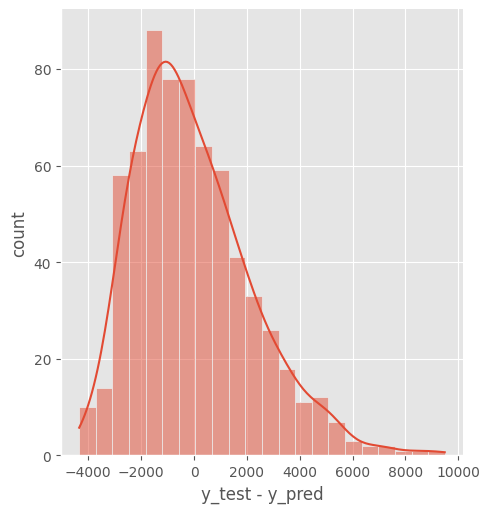

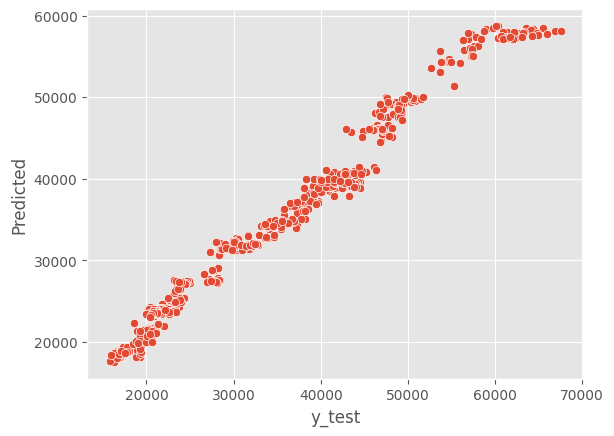

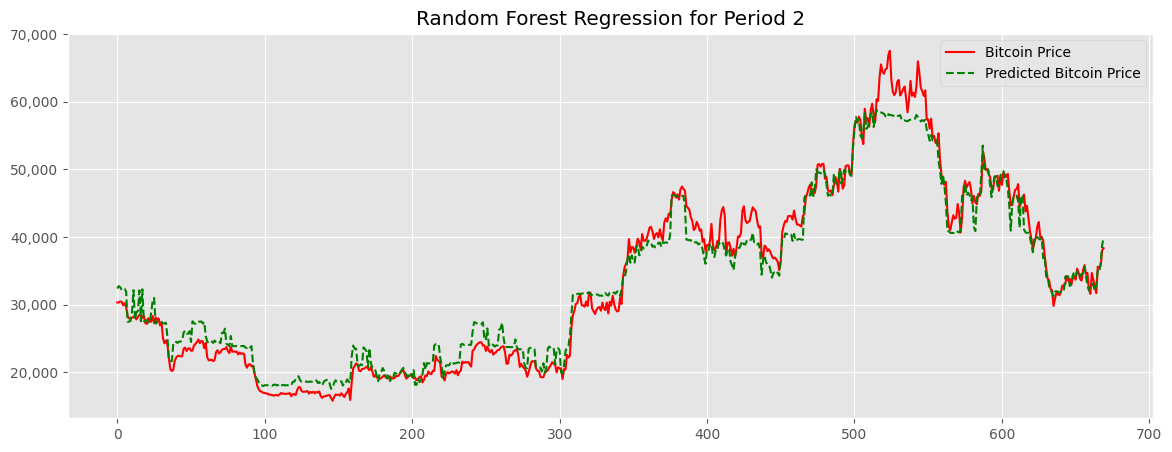

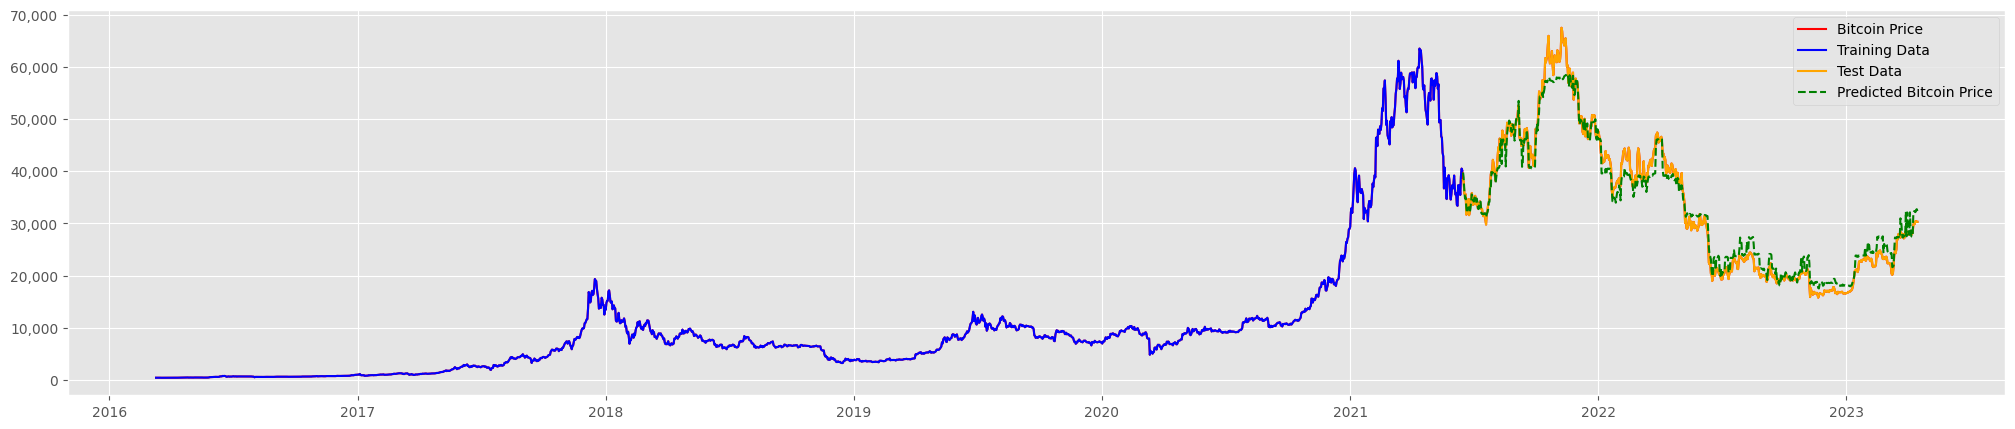

In [173]:
base_accuracy = AUC(base_model, X_test, y_test, X_train, y_train)

### Evaluate the Best Random Search Model

Model Performance
******************************
Test accuracy for train set
Root Mean Square Error (RMSE): 1459.5147850026326
Mean Absolute Percentage Error (MAPE): 0.09840951497865431

Accuracy:  0.640665626625065

Test accuracy for test set
Root Mean Square Error (RMSE): 4012.359534261657
 Mean Absolute Percentage Error (MAPE): 0.07807991715475832

Accuracy:  0.42750373692077726



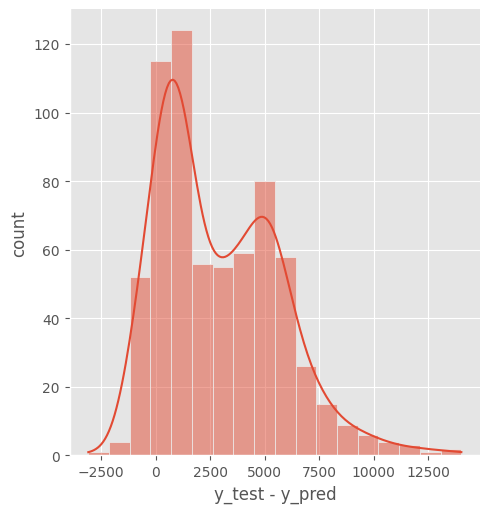

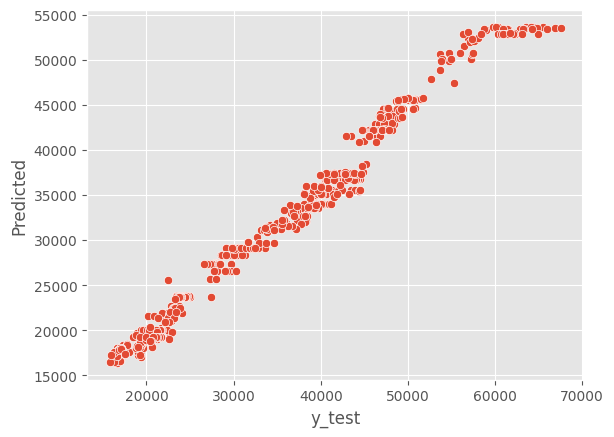

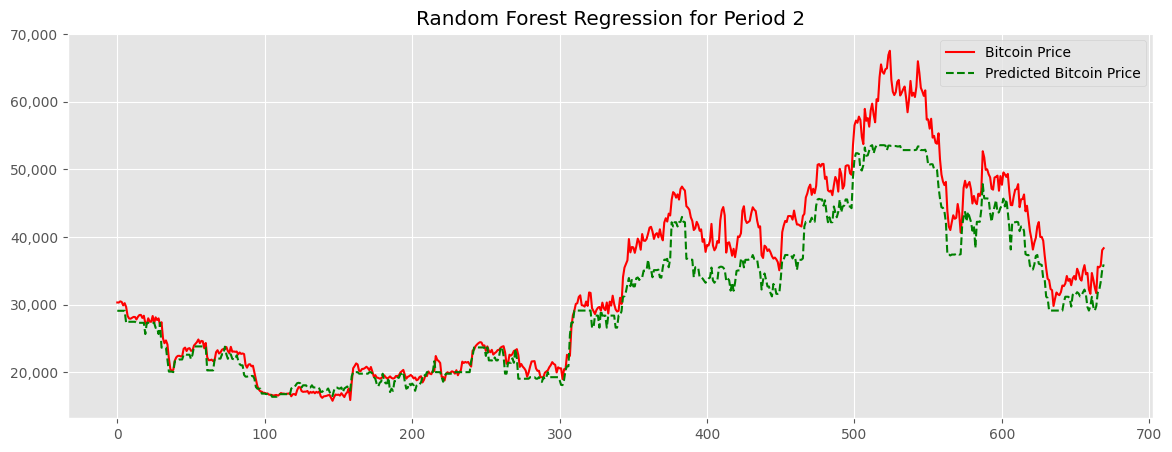

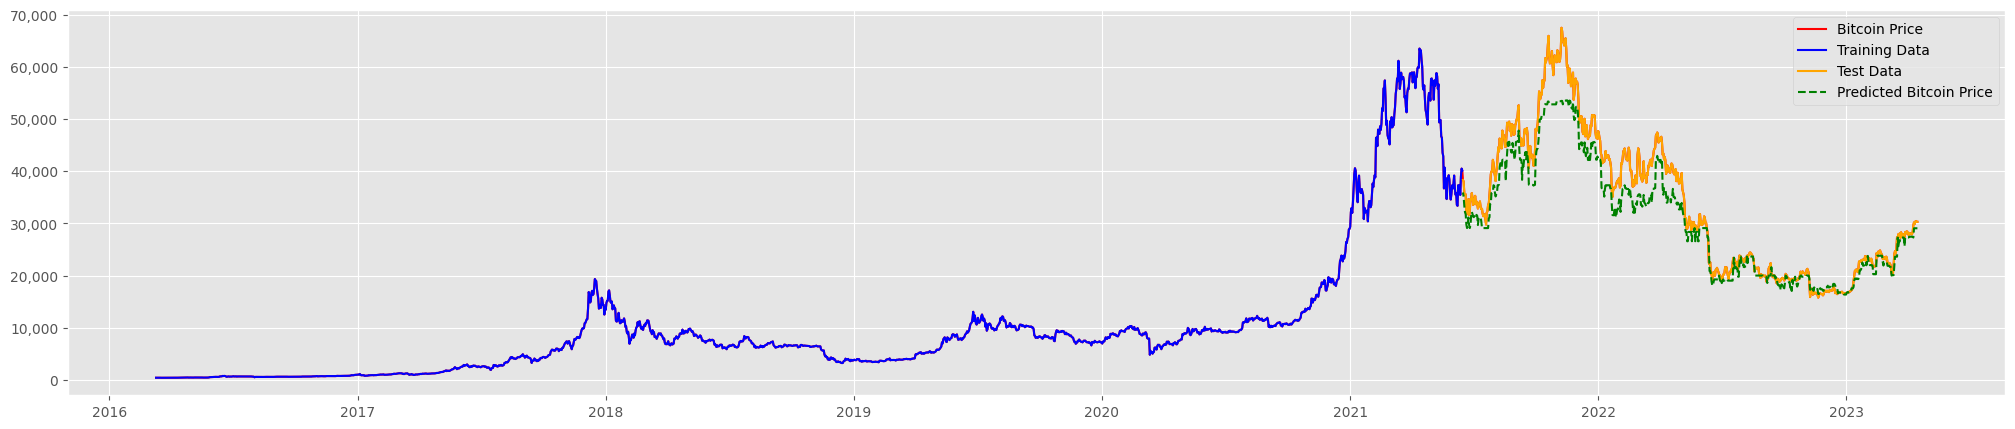

In [174]:
best_random = best_random.best_estimator_
random_accuracy = AUC(best_random, X_test, y_test, X_train, y_train)

## Grid Search

We can now perform grid search building on the result from the random search. We will test a range of hyperparameters around the best values returned by random search.

In [175]:
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
SEARCH_PARAMS = {
    'learning_rate': [0.09, 0.1],
    'max_depth': [4, 6, 8, 10],
    'num_leaves': [20, 24, 27, 31],
    'subsample': [0.9, 1.0],
}

FIXED_PARAMS = {
    'objective': ['regression'],
    'metric': ['rmse'],
    'max_bin': [500],
    'boosting_type': ['dart'],
    'random_state' : [42]}
print(SEARCH_PARAMS)

param_distributions = {**SEARCH_PARAMS, **FIXED_PARAMS}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = base_model, param_grid = param_distributions, 
                          cv = 3, n_jobs = -1, verbose = 2, return_train_score=True)

{'learning_rate': [0.09, 0.1], 'max_depth': [4, 6, 8, 10], 'num_leaves': [20, 24, 27, 31], 'subsample': [0.9, 1.0]}


In [176]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train);

Fitting 3 folds for each of 64 candidates, totalling 192 fits


In [177]:
grid_search.best_params_

{'boosting_type': 'dart',
 'learning_rate': 0.09,
 'max_bin': 500,
 'max_depth': 6,
 'metric': 'rmse',
 'num_leaves': 31,
 'objective': 'regression',
 'random_state': 42,
 'subsample': 0.9}

#### Evaluate the Best Model from Grid Search

Model Performance
******************************
Test accuracy for train set
Root Mean Square Error (RMSE): 1676.8169285881927
Mean Absolute Percentage Error (MAPE): 0.10967655016908605

Accuracy:  0.6604264170566823

Test accuracy for test set
Root Mean Square Error (RMSE): 4533.0775632272625
 Mean Absolute Percentage Error (MAPE): 0.09026239618990708

Accuracy:  0.43647234678624813



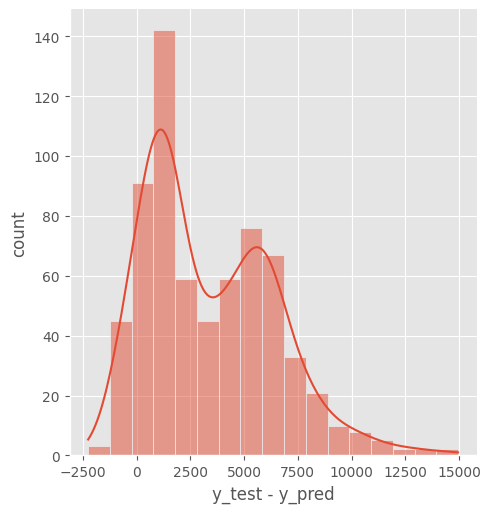

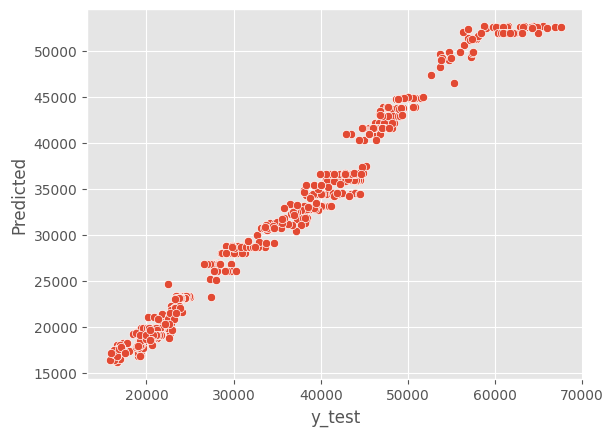

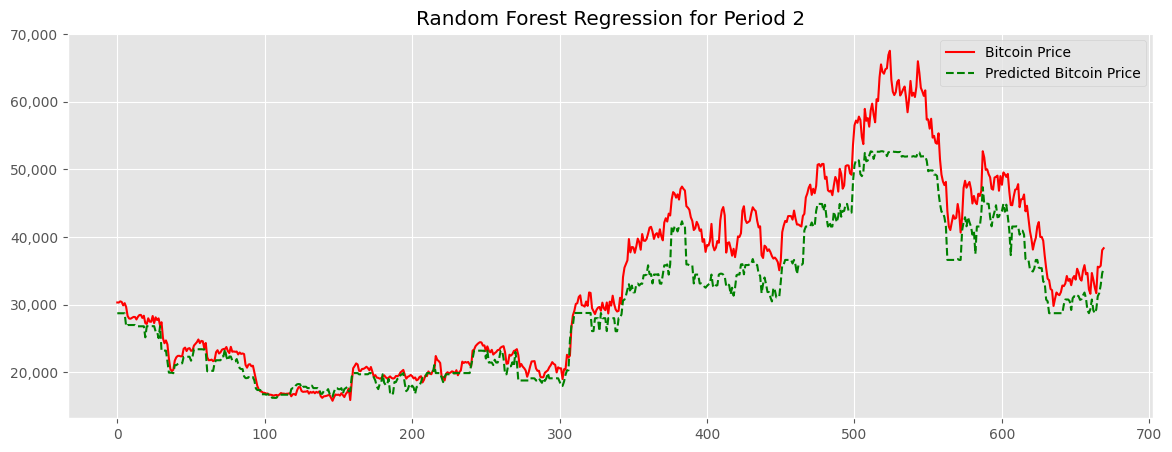

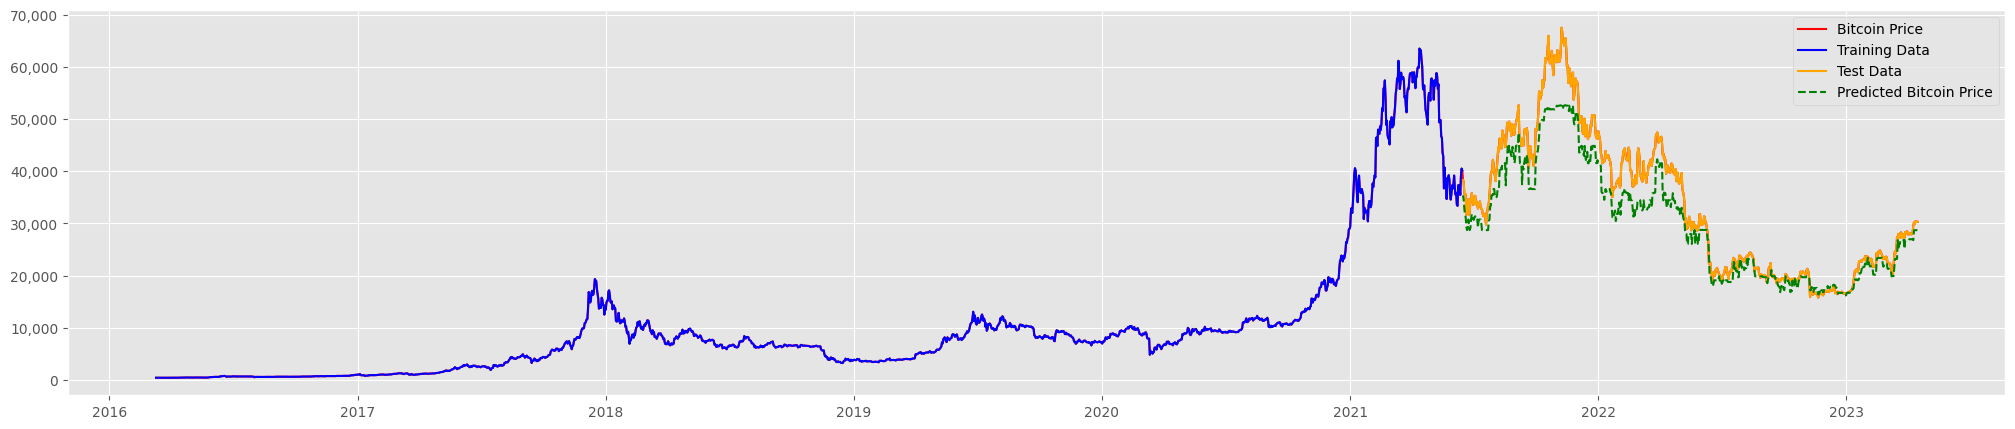

In [178]:
best_grid = grid_search.best_estimator_
grid_accuracy = AUC(best_grid, X_test, y_test, X_train, y_train)

Final Model Parameters:

{'boosting_type': 'dart',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.09,
 'max_bin': 500,
 'max_depth': 6,
 'metric': 'rmse',
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': 'regression',
 'random_state': 42,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 0.9,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}


Model Performance
******************************
Test accuracy for train set
Root Mean Square Error (RMSE): 1676.8169285881927
Mean Absolute Percentage Error (MAPE): 0.10967655016908605

Accuracy:  0.6604264170566823

Test accuracy for test set
Root Mean Square Error (RMSE): 4533.0775632272625
 Mean Absolute Percentage Error (MAPE): 0.09026239618990708

Accuracy:  0.43647234678624813



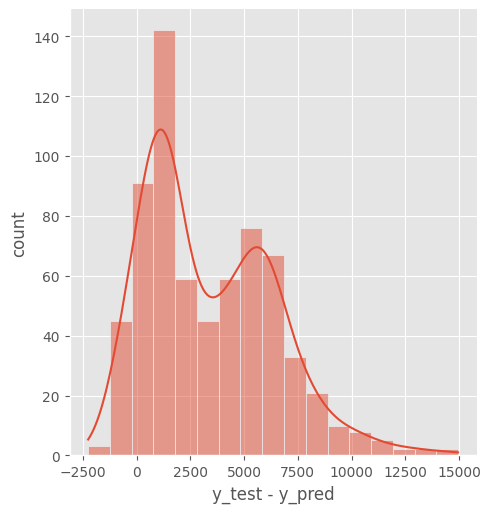

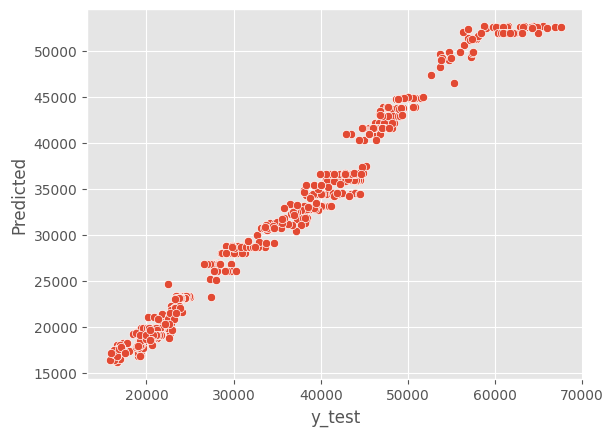

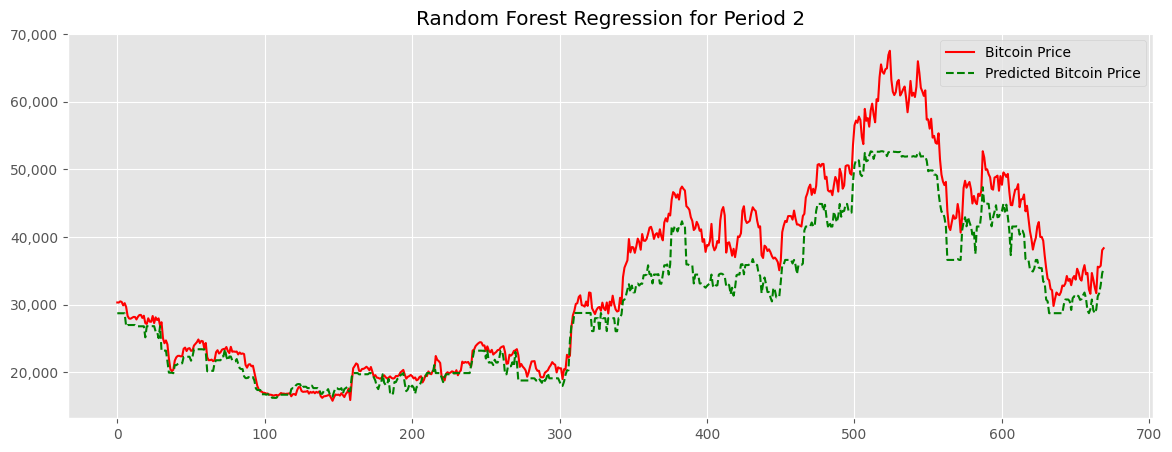

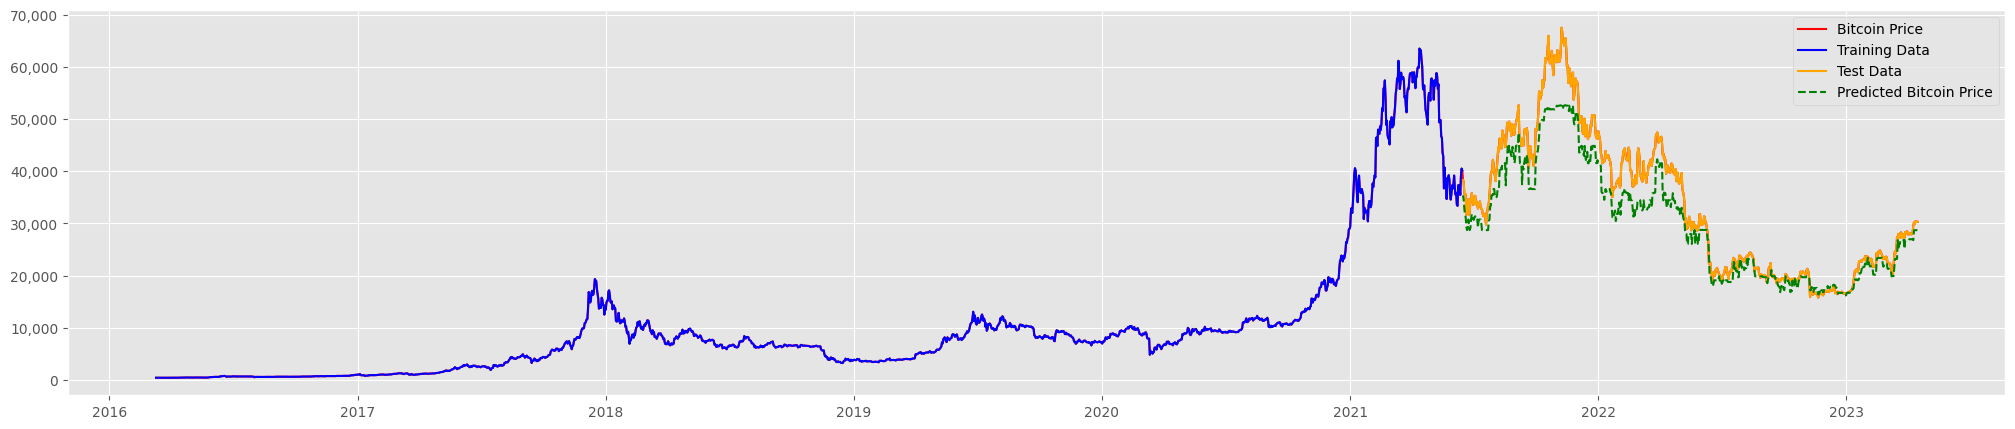

In [179]:
final_model = grid_search.best_estimator_

print('Final Model Parameters:\n')
pprint(final_model.get_params())
print('\n')
grid_final_accuracy = AUC(final_model, X_test, y_test, X_train, y_train)

## Comparison of All Improvement Techniques

In [180]:
import time

In [181]:
# Evaluate run time and prediction accuracy
def evaluate_model(model, X_train, y_train, X_test, y_test):
    n_trees = model.get_params()['n_estimators']
    n_features = X_train.shape[1]
    
    # Train and predict 10 times to evaluate time and accuracy
    predictions_test = []
    predictions_train = []
    run_times = []
    for _ in range(10):
        start_time = time.time()
        model.fit(X_train, y_train)
        predictions_test.append(model.predict(X_test))
        predictions_train.append(model.predict(X_train))
    
        end_time = time.time()
        run_times.append(end_time - start_time)
    
    # Run time and predictions need to be averaged
    run_time = np.mean(run_times)
    predictions_test = np.mean(np.array(predictions_test), axis = 0)
    predictions_train = np.mean(np.array(predictions_train), axis = 0)
   

    count = 0
    for i in range(1,len(y_test)):
        if (y_test[i] - y_test[i-1]) * (predictions_test[i] - predictions_test[i-1]) > 0:
            count += 1
    print('Model Performance')
    print(30*'*')
    print("Test accuracy for train set")
    #RMSE
    rmse_train = np.sqrt(mean_squared_error(y_train, predictions_train))
    print("Root Mean Square Error (RMSE):", rmse_train)

    #MAPE
    mape_train = mean_absolute_percentage_error(y_train, predictions_train)
    print("Mean Absolute Percentage Error (MAPE):", mape_train)
    print()

    print("Test accuracy for test set")
    #RMSE
    rmse_test = np.sqrt(mean_squared_error(y_test, predictions_test))
    print("Root Mean Square Error (RMSE):", rmse_test)

    #MAPE
    mape_test = mean_absolute_percentage_error(y_test, predictions_test)
    print(" Mean Absolute Percentage Error (MAPE):", mape_test)
    print()
    
    AUC = count/(len(y_test)-1)
    print("Accuracy: ", AUC)
    
    # Return results in a dictionary
    results = {'time': run_time, 'RMSE_train': rmse_train, 'RMSE_test': rmse_test, 'MAPE_train' : mape_train, 'MAPE_test': mape_test, 'accuracy': AUC, 'n_trees': n_trees, 'n_features': n_features}
    
    return results

In [182]:
#### Default

In [183]:
base_results = evaluate_model(base_model, X_train, y_train, X_test, y_test)

Model Performance
******************************
Test accuracy for train set
Root Mean Square Error (RMSE): 178.96646390937025
Mean Absolute Percentage Error (MAPE): 0.009742014332968016

Test accuracy for test set
Root Mean Square Error (RMSE): 2217.109456693792
 Mean Absolute Percentage Error (MAPE): 0.058455698774495295

Accuracy:  0.5829596412556054


In [184]:
base_results['model'] = 'base_model'

In [185]:
base_results

{'time': 12.620106315612793,
 'RMSE_train': 178.96646390937025,
 'RMSE_test': 2217.109456693792,
 'MAPE_train': 0.009742014332968016,
 'MAPE_test': 0.058455698774495295,
 'accuracy': 0.5829596412556054,
 'n_trees': 100,
 'n_features': 22,
 'model': 'base_model'}

#### Random Search Best Model

In [186]:
random_results = evaluate_model(best_random, X_train, y_train, X_test, y_test)

Model Performance
******************************
Test accuracy for train set
Root Mean Square Error (RMSE): 1459.5147850026324
Mean Absolute Percentage Error (MAPE): 0.09840951497865434

Test accuracy for test set
Root Mean Square Error (RMSE): 4012.3595342616577
 Mean Absolute Percentage Error (MAPE): 0.07807991715475833

Accuracy:  0.42750373692077726


In [187]:
random_results['model'] = 'best_random'

In [188]:
random_results

{'time': 1.1572433948516845,
 'RMSE_train': 1459.5147850026324,
 'RMSE_test': 4012.3595342616577,
 'MAPE_train': 0.09840951497865434,
 'MAPE_test': 0.07807991715475833,
 'accuracy': 0.42750373692077726,
 'n_trees': 100,
 'n_features': 22,
 'model': 'best_random'}

#### First Grid Search Best Model

In [189]:
first_grid_results = evaluate_model(best_grid, X_train, y_train, X_test, y_test)
first_grid_results['model'] = 'first_grid'

Model Performance
******************************
Test accuracy for train set
Root Mean Square Error (RMSE): 1676.8169285881925
Mean Absolute Percentage Error (MAPE): 0.10967655016908605

Test accuracy for test set
Root Mean Square Error (RMSE): 4533.0775632272625
 Mean Absolute Percentage Error (MAPE): 0.09026239618990711

Accuracy:  0.43647234678624813


In [190]:
first_grid_results

{'time': 0.9659702062606812,
 'RMSE_train': 1676.8169285881925,
 'RMSE_test': 4533.0775632272625,
 'MAPE_train': 0.10967655016908605,
 'MAPE_test': 0.09026239618990711,
 'accuracy': 0.43647234678624813,
 'n_trees': 100,
 'n_features': 22,
 'model': 'first_grid'}

#### Second Grid Search Best Model

In [191]:
second_grid_results = evaluate_model(best_grid, X_train, y_train, X_test, y_test)
second_grid_results['model'] = 'second_grid'

Model Performance
******************************
Test accuracy for train set
Root Mean Square Error (RMSE): 1676.8169285881925
Mean Absolute Percentage Error (MAPE): 0.10967655016908605

Test accuracy for test set
Root Mean Square Error (RMSE): 4533.0775632272625
 Mean Absolute Percentage Error (MAPE): 0.09026239618990711

Accuracy:  0.43647234678624813


In [192]:
second_grid_results

{'time': 0.8256364583969116,
 'RMSE_train': 1676.8169285881925,
 'RMSE_test': 4533.0775632272625,
 'MAPE_train': 0.10967655016908605,
 'MAPE_test': 0.09026239618990711,
 'accuracy': 0.43647234678624813,
 'n_trees': 100,
 'n_features': 22,
 'model': 'second_grid'}

## Comparison

In [193]:
comparison = {'accuracy': [],
    'RMSE_train': [],
    'RMSE_test': [],
    'MAPE_train': [],
    'MAPE_test': [],
    'model': [],
    'n_features': [],
    'n_trees': [],
    'time': []}
for model in [base_results, random_results, first_grid_results, second_grid_results]:
    comparison['accuracy'].append(round(model['accuracy'], 3))
    comparison['RMSE_train'].append(round(model['RMSE_train'], 3))
    comparison['RMSE_test'].append(round(model['RMSE_test'], 3))
    comparison['MAPE_train'].append(round(model['MAPE_train'], 3))
    comparison['MAPE_test'].append(round(model['MAPE_test'], 3))
    comparison['model'].append(model['model'])
    comparison['n_features'].append(model['n_features'])
    comparison['n_trees'].append(int(model['n_trees']))
    comparison['time'].append(round(model['time'], 4))


In [194]:
comparison = pd.DataFrame.from_dict(comparison, orient = 'columns')

In [195]:
comparison[['model', 'accuracy', 'RMSE_train', 'RMSE_test', 'MAPE_train', 'MAPE_test', 'n_features', 'n_trees', 'time']]


,model,accuracy,RMSE_train,RMSE_test,MAPE_train,MAPE_test,n_features,n_trees,time
0,base_model,0.583,178.966,2217.109,0.010,0.058,22,100,12.6201
1,best_random,0.428,1459.515,4012.360,0.098,0.078,22,100,1.1572
2,first_grid,0.436,1676.817,4533.078,0.110,0.090,22,100,0.9660
3,second_grid,0.436,1676.817,4533.078,0.110,0.090,22,100,0.8256


## Plotting 

In [196]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.style.use('ggplot')

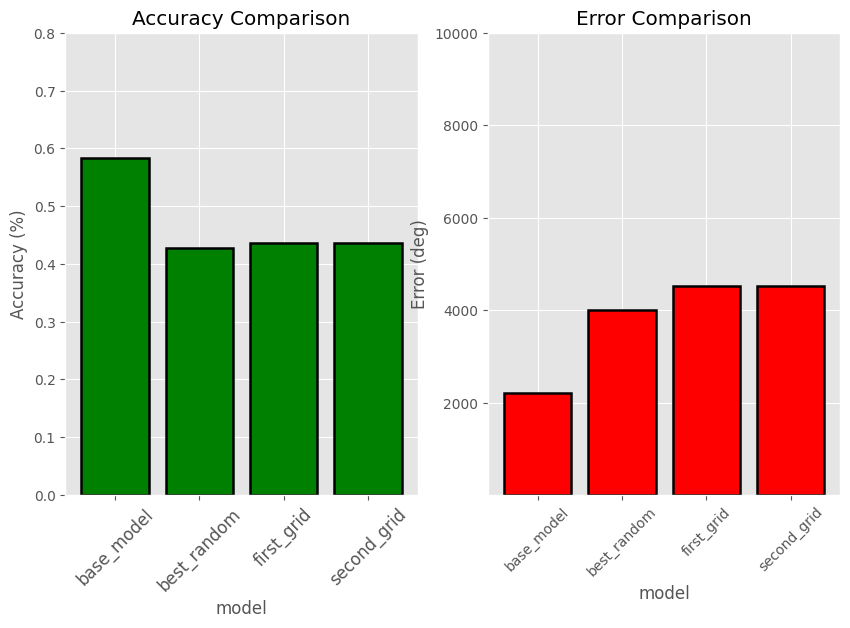

In [197]:
xvalues = list(range(len(comparison)))
plt.subplots(1, 2, figsize=(10, 6))
plt.subplot(121)
plt.bar(xvalues, comparison['accuracy'], color = 'g', edgecolor = 'k', linewidth = 1.8)
plt.xticks(xvalues, comparison['model'], rotation = 45, fontsize = 12)
plt.ylim(ymin = 0, ymax = 0.8)
plt.xlabel('model'); plt.ylabel('Accuracy (%)'); plt.title('Accuracy Comparison');

plt.subplot(122)
plt.bar(xvalues, comparison['RMSE_test'], color = 'r', edgecolor = 'k', linewidth = 1.8)
plt.xticks(xvalues, comparison['model'], rotation = 45)
plt.ylim(ymin = 3.5, ymax = 10000)
plt.xlabel('model'); plt.ylabel('Error (deg)'); plt.title('Error Comparison');
plt.show();

## Importance Feature

In [198]:
features = X_train.columns
# Get numerical feature importances
importances = list(final_model.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 4)) for feature, importance in zip(features, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
for pair in feature_importances:
    print('Variable: {:20} Importance: {}'.format(*pair))

Variable: BTC_high             Importance: 1353
Variable: BTC_low              Importance: 1207
Variable: BTC_open             Importance: 131
Variable: ETH                  Importance: 43
Variable: LTC                  Importance: 38
Variable: Total_Fees(USD)      Importance: 28
Variable: DOGE                 Importance: 28
Variable: JP225                Importance: 28
Variable: BTC_volume           Importance: 24
Variable: XRP                  Importance: 21
Variable: S&P500               Importance: 18
Variable: SILVER               Importance: 17
Variable: COPPER               Importance: 11
Variable: Active_Addr_Cnt      Importance: 10
Variable: Difficulty           Importance: 10
Variable: GOLD                 Importance: 9
Variable: Mean_Hashrate        Importance: 8
Variable: Sum_Block_Weight     Importance: 7
Variable: DJI                  Importance: 4
Variable: Mean_Tx_size(native_units) Importance: 2
Variable: Xfer_Cnt             Importance: 1
Variable: Mean_Block_Size(in_

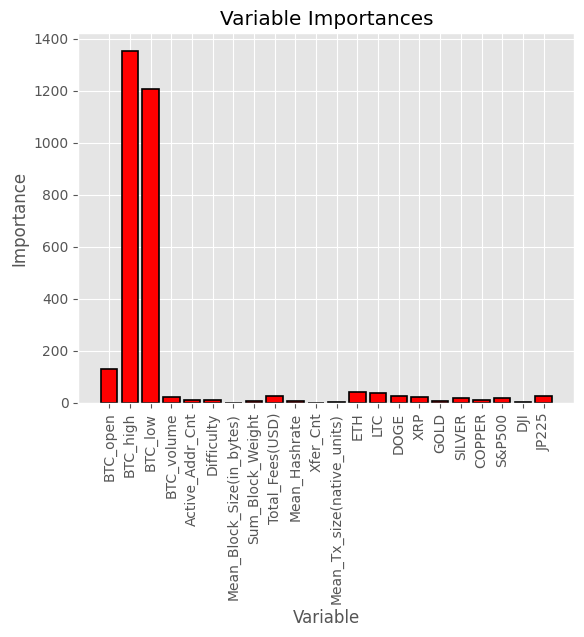

In [199]:
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2)
# Tick labels for x axis
plt.xticks(x_values, features, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

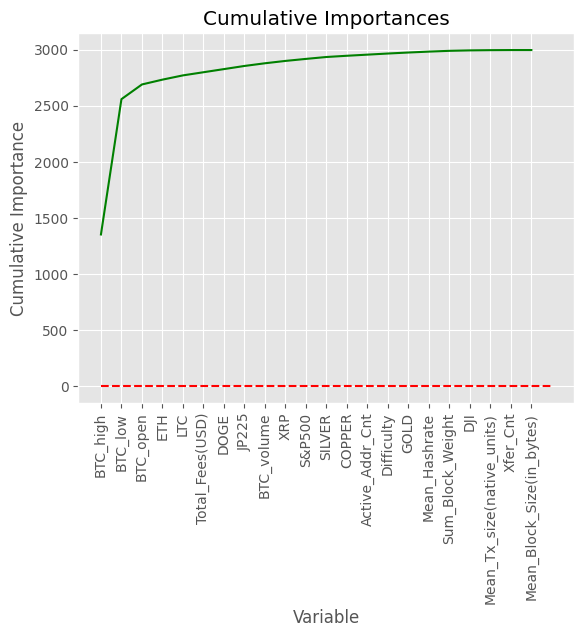

In [200]:
# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]
# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)
# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')
# Draw line at 90% of importance retained
plt.hlines(y = 0.9, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')
# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')
# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances');

In [201]:
# Find number of features for cumulative importance of 90%
# Add 1 because Python is zero-indexed
num = np.where(cumulative_importances > 0.9)[0][0] + 1
print('Number of features for 90% importance:', num)

Number of features for 90% importance: 1


In [202]:
# Extract the names of the most important features
important_feature_names = [feature[0] for feature in feature_importances[0:num]]
print(important_feature_names)

['BTC_high']


<Axes: >

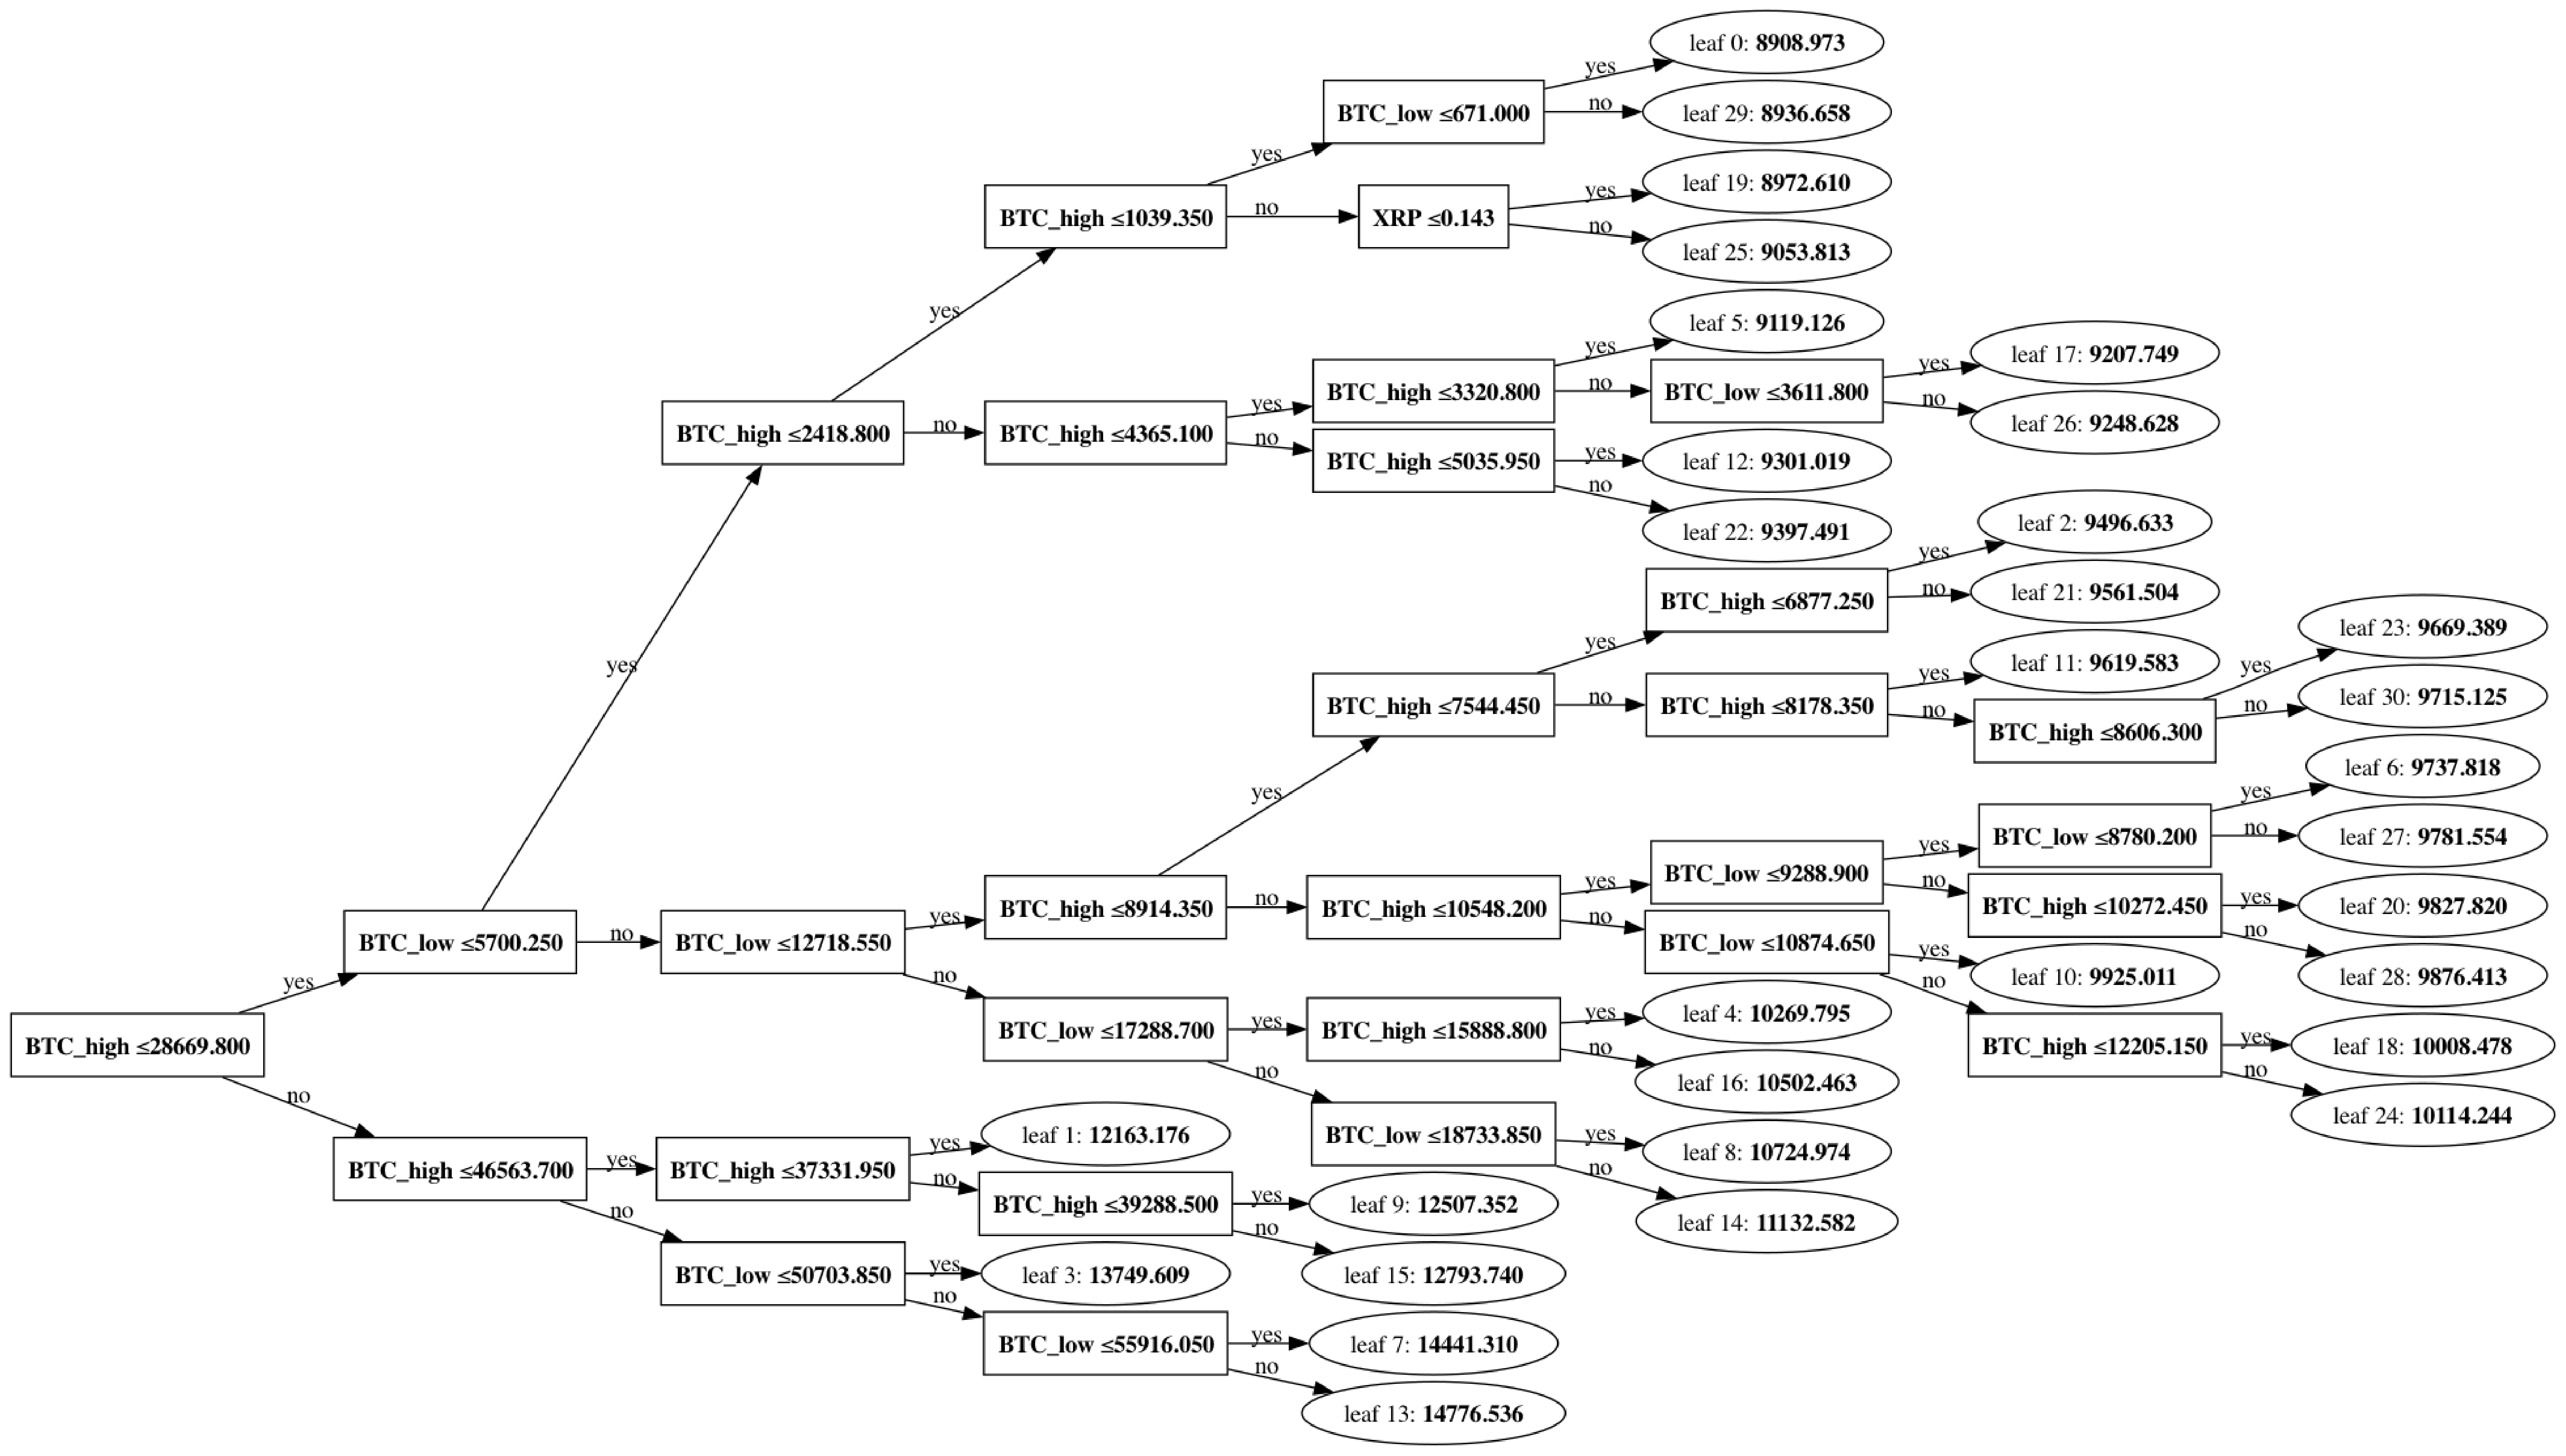

In [203]:
lgb.plot_tree(base_model, tree_index = 0, figsize=(80,80))


In [204]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import accuracy_score

def calculate_accuracy(model,X_train, y_train, X_test, y_test):
    # Regression model
    model.fit(X_train, y_train)
    y_pred_regression = model.predict(X_test)
    
    # Classification model
    classification_model = RandomForestClassifier()
    classification_model.fit(X_train, y_train > 0)  # Phân loại thành nhóm "tăng" và "giảm"
    y_pred_classification = classification_model.predict(X_test)

    # Compare predictions and calculate accuracy
    num_correct = 0
    num_total = len(y_test)

    for i in range(len(y_test)):
        if y_pred_classification[i] == 1:  # Dự đoán nhãn "tăng"
            if y_pred_regression[i] > y_test[i]:  # Dự đoán giá tăng
                num_correct += 1
        else:  # Dự đoán nhãn "giảm"
            if y_pred_regression[i] < y_test[i]:  # Dự đoán giá giảm
                num_correct += 1

    accuracy = num_correct / num_total
    
    # Calculate RMSE
    rmse = mean_squared_error(y_test, y_pred_regression, squared=False)
    
    # Calculate MSE
    mse = mean_squared_error(y_test, y_pred_regression)
    
    # Calculate MAPE
    mape = mean_absolute_percentage_error(y_test, y_pred_regression)
    
    return accuracy, rmse, mse, mape

In [237]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.metrics import precision_score, recall_score, f1_score


def calculate_accuracy(model, X_train, y_train, X_test, y_test):
    # Regression model
    model.fit(X_train, y_train)
    y_pred_regression_train = model.predict(X_train)
    y_pred_regression_test = model.predict(X_test)
    
    # Classification model
    classification_model = RandomForestClassifier()
    classification_model.fit(X_train, y_train > 0)
    y_pred_classification_train = classification_model.predict(X_train)
    y_pred_classification_test = classification_model.predict(X_test)

    # Compare predictions and calculate accuracy for test set
    num_correct_test = 0
    num_total_test = len(y_test)

    for i in range(1,len(y_test)):
        if y_pred_classification_test[i] == 1:  # Dự đoán nhãn "tăng"
            if y_pred_regression_test[i] > y_pred_regression_test[i-1]:  # Dự đoán giá tăng
                num_correct_test += 1
        else:  # Dự đoán nhãn "giảm"
            if y_pred_regression_test[i] < y_pred_regression_test[i-1]:  # Dự đoán giá giảm
                num_correct_test += 1

    accuracy_test = num_correct_test / num_total_test
    
    # Compare predictions and calculate accuracy for train set
    num_correct_train = 0
    num_total_train = len(y_train)

    for i in range(1,len(y_train)):
        if y_pred_classification_train[i] == 1:  # Dự đoán nhãn "tăng"
            if y_pred_regression_train[i] > y_pred_regression_train[i-1]:  # Dự đoán giá tăng
                num_correct_train += 1
        else:  # Dự đoán nhãn "giảm"
            if y_pred_regression_train[i] < y_pred_regression_train[i-1]:  # Dự đoán giá giảm
                num_correct_train += 1

    accuracy_train = num_correct_train / num_total_train
    
    # Calculate RMSE for regression
    rmse_regression_train = mean_squared_error(y_train, y_pred_regression_train, squared=False)
    rmse_regression_test = mean_squared_error(y_test, y_pred_regression_test, squared=False)
    
    # Calculate MAPE for regression
    mape_regression_train = mean_absolute_percentage_error(y_train, y_pred_regression_train)
    mape_regression_test = mean_absolute_percentage_error(y_test, y_pred_regression_test)
    
    # Calculate accuracy for trend prediction
    num_correct_trend = 0
    num_total_trend = len(y_test) - 1

    for i in range(1, len(y_test)):
        if (y_test[i] - y_test[i-1] > 0 and y_pred_regression_test[i] - y_pred_regression_test[i-1] > 0) or \
           (y_test[i] - y_test[i-1] < 0 and y_pred_regression_test[i] - y_pred_regression_test[i-1] < 0):
            num_correct_trend += 1

    accuracy_trend = num_correct_trend / num_total_trend
    
    # Calculate precision, recall, and f1-score for trend prediction
    precision_trend = precision_score((y_test[1:] - y_test[:-1]) > 0, (y_pred_regression_test[1:] - y_pred_regression_test[:-1]) > 0)
    recall_trend = recall_score((y_test[1:] - y_test[:-1]) > 0, (y_pred_regression_test[1:] - y_pred_regression_test[:-1]) > 0)
    f1_trend = f1_score((y_test[1:] - y_test[:-1]) > 0, (y_pred_regression_test[1:] - y_pred_regression_test[:-1]) > 0)
    
    return accuracy_train, accuracy_test, rmse_regression_train, rmse_regression_test, mape_regression_train, mape_regression_test, accuracy_trend, precision_trend, recall_trend, f1_trend

In [238]:
accuracy_train, accuracy_test, rmse_regression_train, rmse_regression_test, mape_regression_train, mape_regression_test, accuracy_trend, precision_trend, recall_trend, f1_trend = calculate_accuracy(base_model, X_train, y_train, X_test, y_test)

print("Accuracy - Train:", accuracy_train)
print("Accuracy - Test:", accuracy_test)

print("Regression Model - Train:")
print("RMSE:", rmse_regression_train)
print("MAPE:", mape_regression_train)

print("Regression Model - Test:")
print("RMSE:", rmse_regression_test)
print("MAPE:", mape_regression_test)

print("Classification Model:")
print("Accuracy - Trend:", accuracy_trend)
print("Precision:", precision_trend)
print("Recall:", recall_trend)
print("F1:", f1_trend)

Accuracy - Train: 0.43814968814968813
Accuracy - Test: 0.46567164179104475
Regression Model - Train:
RMSE: 178.9664639093701
MAPE: 0.009742014332968016
Regression Model - Test:
RMSE: 2217.109456693792
MAPE: 0.058455698774495295
Classification Model:
Accuracy - Trend: 0.5829596412556054
Precision: 0.6378205128205128
Recall: 0.5751445086705202
F1: 0.6048632218844985


In [239]:
accuracy_train, accuracy_test, rmse_regression_train, rmse_regression_test, mape_regression_train, mape_regression_test, accuracy_trend, precision_trend, recall_trend, f1_trend = calculate_accuracy(best_random, X_train, y_train, X_test, y_test)

print("Accuracy - Train:", accuracy_train)
print("Accuracy - Test:", accuracy_test)

print("Regression Model - Train:")
print("RMSE:", rmse_regression_train)
print("MAPE:", mape_regression_train)

print("Regression Model - Test:")
print("RMSE:", rmse_regression_test)
print("MAPE:", mape_regression_test)

print("Classification Model:")
print("Accuracy - Trend:", accuracy_trend)
print("Precision:", precision_trend)
print("Recall:", recall_trend)
print("F1:", f1_trend)

Accuracy - Train: 0.37525987525987525
Accuracy - Test: 0.3253731343283582
Regression Model - Train:
RMSE: 1459.5147850026326
MAPE: 0.09840951497865431
Regression Model - Test:
RMSE: 4012.359534261657
MAPE: 0.07807991715475832
Classification Model:
Accuracy - Trend: 0.42750373692077726
Precision: 0.6743119266055045
Recall: 0.42485549132947975
F1: 0.5212765957446808


In [240]:
accuracy_train, accuracy_test, rmse_regression_train, rmse_regression_test, mape_regression_train, mape_regression_test, accuracy_trend, precision_trend, recall_trend, f1_trend = calculate_accuracy(best_grid, X_train, y_train, X_test, y_test)

print("Accuracy - Train:", accuracy_train)
print("Accuracy - Test:", accuracy_test)

print("Regression Model - Train:")
print("RMSE:", rmse_regression_train)
print("MAPE:", mape_regression_train)

print("Regression Model - Test:")
print("RMSE:", rmse_regression_test)
print("MAPE:", mape_regression_test)

print("Classification Model:")
print("Accuracy - Trend:", accuracy_trend)
print("Precision:", precision_trend)
print("Recall:", recall_trend)
print("F1:", f1_trend)

Accuracy - Train: 0.3877338877338877
Accuracy - Test: 0.3328358208955224
Regression Model - Train:
RMSE: 1676.8169285881927
MAPE: 0.10967655016908605
Regression Model - Test:
RMSE: 4533.0775632272625
MAPE: 0.09026239618990708
Classification Model:
Accuracy - Trend: 0.43647234678624813
Precision: 0.6636771300448431
Recall: 0.4277456647398844
F1: 0.5202108963093146
